<h3>Import Library<h3>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import os
from PIL import Image
import random

<h3>Pengaturan Direktori<h3>

In [2]:
# sapi
# direktori train test
train_dir= r'D:\BANGKIT2023\CAPSTONE\sapiseimbang\train'
test_dir= r'D:\BANGKIT2023\CAPSTONE\sapiseimbang\test'

<h3>Cek Gambar<h3>

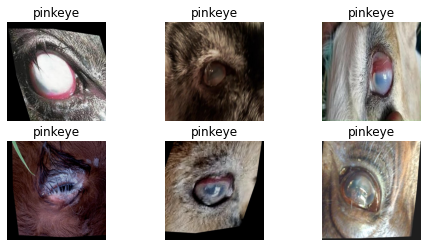

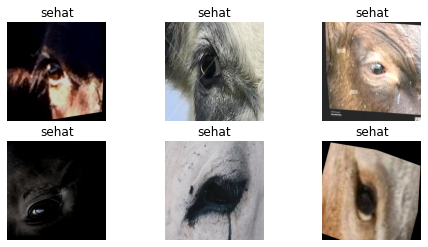

In [3]:
# list nama kelas
class_name = 'pinkeye'
class_name2 = 'sehat'

# list path gambar pada kelas yang dipilih
image_paths = os.listdir(os.path.join(train_dir, class_name))
image_paths2 = os.listdir(os.path.join(train_dir, class_name2))

# memilih 6 gambar secara acak dari kelas yang dipilih
image_paths = random.sample(image_paths, 6)
image_paths2 = random.sample(image_paths2, 6)

# menampilkan 6 gambar dari kelas yang dipilih
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    img = image.load_img(os.path.join(train_dir, class_name, image_paths[i]))
    ax.imshow(img)
    ax.set_title(f"{class_name}")
    ax.axis('off')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    img = image.load_img(os.path.join(train_dir, class_name2, image_paths2[i]))
    ax.imshow(img)
    ax.set_title(f"{class_name2}")
    ax.axis('off')
plt.show()

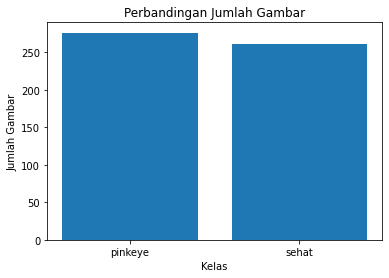

In [4]:
class_names = ['pinkeye', 'sehat']

# menghitung jumlah gambar pada setiap kelas
num_images = []
for class_name in class_names:
    num_images.append(len(os.listdir(os.path.join(train_dir, class_name))))

# menampilkan grafik perbandingan jumlah gambar pada dua kelas
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(class_names, num_images)
ax.set_title('Perbandingan Jumlah Gambar')
ax.set_xlabel('Kelas')
ax.set_ylabel('Jumlah Gambar')
plt.show()

<h3>Preprosesing Dataset<h3>

In [5]:
# ukuran gambar dan batch nantinya
image_size = 224
batch_size = 32

In [6]:
# augmentasi data train
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# yang tes cmn rescale aja
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# mempersiapkan data di preprosesing untuk train dan tes nantinya
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_size, image_size),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(image_size, image_size),
                                                  batch_size=batch_size,
                                                  class_mode='binary')


Found 537 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


<h4>Cek gambar setelah augmentasi<h4>

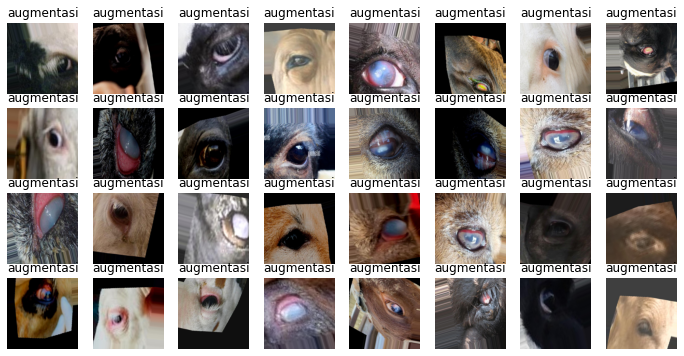

In [8]:
augmented_images, _ = train_generator.next()

# memvisualisasikan gambar setelah augmentasi
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.set_title('augmentasi')
    ax.imshow(augmented_images[i])
    ax.axis('off')
plt.show()

<h3>Pembuatan model CNN<h3>

In [9]:
# model 1
# 5 conv net dan maxpool,1 flatten 2 dense layer
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

<h3>Train Model<h3>

In [13]:
epochs = 10

from tensorflow.keras.callbacks import Callback

class AccuracyCallback(Callback):
    def __init__(self, threshold):
        super(AccuracyCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy'] >= self.threshold:
            self.model.stop_training = True
            print(f"\nTraining stopped as validation accuracy reached {self.threshold}")


accuracy_callback = AccuracyCallback(threshold=0.94)

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=test_generator,
                    callbacks=[accuracy_callback]
)


Epoch 1/10
17/17 [==============================] - 25s 1s/step - loss: 0.6899 - accuracy: 0.5531 - val_loss: 0.6507 - val_accuracy: 0.6429
Epoch 2/10
17/17 [==============================] - 17s 996ms/step - loss: 0.6771 - accuracy: 0.5940 - val_loss: 0.6198 - val_accuracy: 0.7500
Epoch 3/10
17/17 [==============================] - 18s 1s/step - loss: 0.6855 - accuracy: 0.5419 - val_loss: 0.6684 - val_accuracy: 0.6786
Epoch 4/10
17/17 [==============================] - 17s 962ms/step - loss: 0.6690 - accuracy: 0.5978 - val_loss: 0.8120 - val_accuracy: 0.5357
Epoch 5/10
17/17 [==============================] - 17s 965ms/step - loss: 0.6503 - accuracy: 0.6369 - val_loss: 0.6309 - val_accuracy: 0.6429
Epoch 6/10
17/17 [==============================] - 19s 1s/step - loss: 0.6445 - accuracy: 0.6145 - val_loss: 0.6096 - val_accuracy: 0.7143
Epoch 7/10
17/17 [==============================] - 17s 983ms/step - loss: 0.6358 - accuracy: 0.6499 - val_loss: 0.6703 - val_accuracy: 0.6429
Epoch 8/

<h3>Evaluasi<h3>

In [14]:
test_loss, test_acc = model.evaluate(test_generator)
print('akurasi:', test_acc)

1/1 [==============================] - 0s 309ms/step - loss: 0.5491 - accuracy: 0.7500
akurasi: 0.75


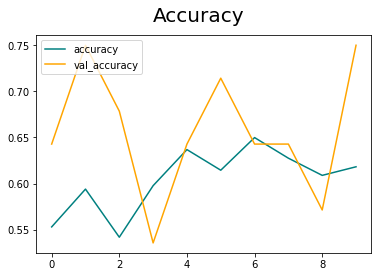

In [15]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

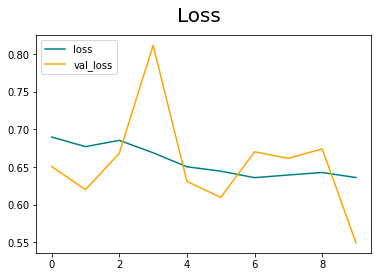

In [16]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

<h3>Tes Model<h3>

In [18]:
img_path = r'D:\BANGKIT2023\CAPSTONE\sapiseimbang\test\pinkeye\Copy-of-00000041_jpg.rf.1e76685ae997f4eeea68bfd523e08243.jpg'
img = image.load_img(img_path, target_size=(image_size, image_size))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)


In [21]:
prediction = model.predict(img)

if prediction < 0.5:
    label="pinkeye"
else:
    label="sehat"

1/1 [==============================] - 0s 40ms/step


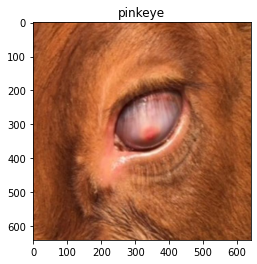

In [22]:
plt.imshow(plt.imread(img_path))
plt.title(label)
plt.show()

In [23]:
model.predict(img)

1/1 [==============================] - 0s 60ms/step


array([[0.]], dtype=float32)

<h3>Simpan Model<h3>

In [ ]:
model.save('z.h5')

<h3>Tes folder<h3>

1/1 [==============================] - 0s 43ms/step


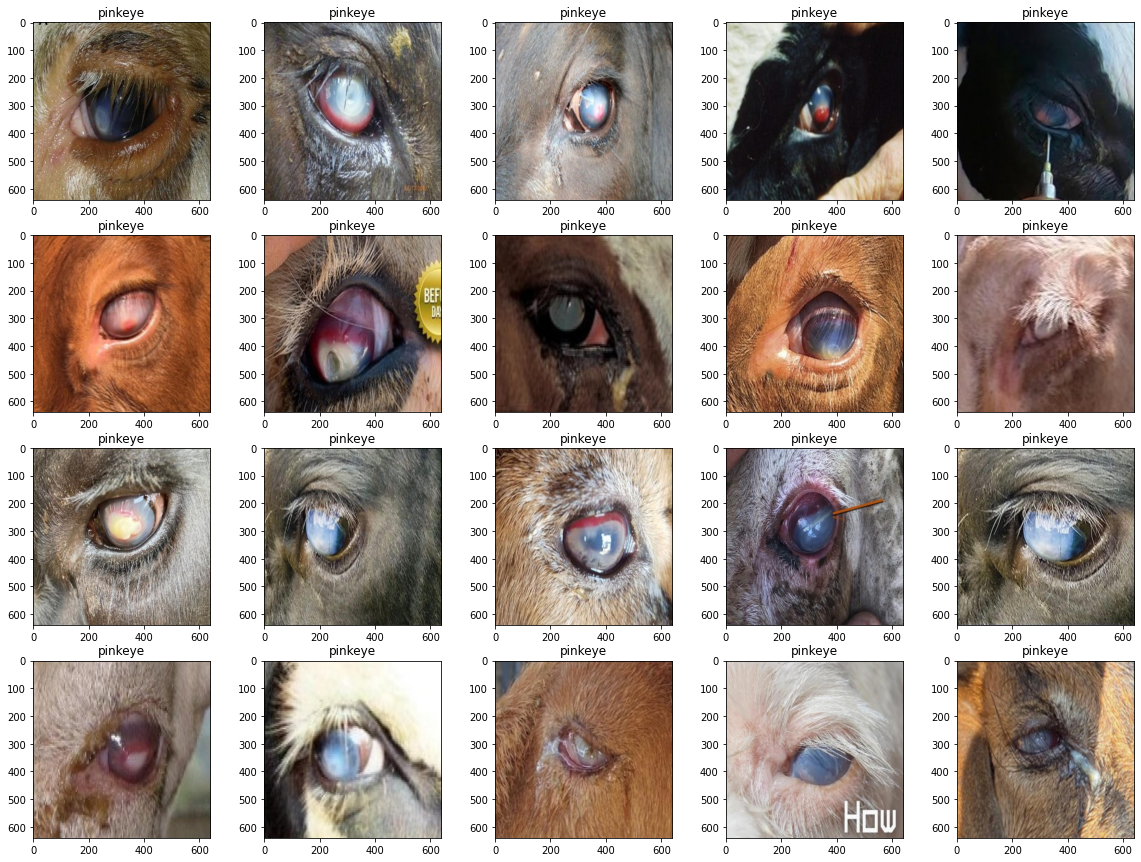

In [25]:
# model = tf.keras.models.load_model('zzzzzzzz.h5')
test_dir = r'D:\BANGKIT2023\CAPSTONE\sapiseimbang\test\pinkeye'

fig, axs = plt.subplots(4, len(os.listdir(test_dir)) // 4, figsize=(20, 15))

for i, img_name in enumerate(os.listdir(test_dir)):
    img_path = os.path.join(test_dir, img_name)
    img = image.load_img(img_path, target_size=(image_size, image_size))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    if prediction < 0.5:
        label = "pinkeye"
    else:
        label = "sehat"
    axs.flatten()[i].imshow(plt.imread(img_path))
    axs.flatten()[i].set_title(label)

plt.show()

1/1 [==============================] - 0s 170ms/step
Confusion Matrix:
[[20  0]
 [ 7  1]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85        20
         1.0       1.00      0.12      0.22         8

    accuracy                           0.75        28
   macro avg       0.87      0.56      0.54        28
weighted avg       0.81      0.75      0.67        28



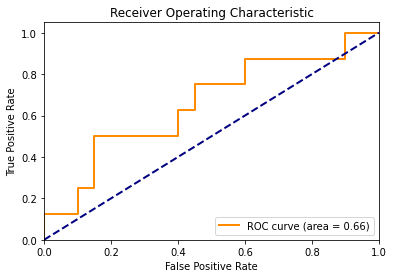

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
# Generate predictions for the test set
test_images, test_labels = test_generator.next()
predictions = model.predict(test_images)

# Convert predicted probabilities to class labels
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Compute classification report
report = classification_report(test_labels, predicted_labels)
print("Classification Report:")
print(report)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()